# 3rd Data Science Project

In this project, we have housing price data from Boston, Massachusetts, USA. We'll be doing some analysis using Python.

Let's start by loading packages.

# Load Packages:

In [3]:
#Load Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import math
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import mean_squared_error

Next, let's load the data.

# Load Data

In [4]:
# Load Data
from sklearn.datasets import load_boston
boston = load_boston()

Putting the data in panda's dataframe. Inspecting the data and looking at first few rows of data by using **head()** function

In [5]:
boston_df = pd.DataFrame(boston.data)
boston_df.columns = boston.feature_names
print(boston_df.head())

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  
0     15.3  396.90   4.98  
1     17.8  396.90   9.14  
2     17.8  392.83   4.03  
3     18.7  394.63   2.94  
4     18.7  396.90   5.33  


We see that here MEDV column is missing. We'll get this by boston.target and insert this in the dataframe

In [6]:
#Adding MEDV column in df
boston_df['MEDV'] = boston.target

In this project, we'll be inspecting a variable which is **RM(average no. of rooms per dwelling)**. Now its time to compute its mean and standard deviation in our sample.

# Mean and Standard Deviation

In [7]:
rooms = boston_df.RM

#mean of rooms
print(np.mean(rooms))

#std of rooms
print(np.std(rooms))

6.284634387351779
0.7019225143345689


# Histogram for avg no. of rooms

We can briefly check the skewness of variable.

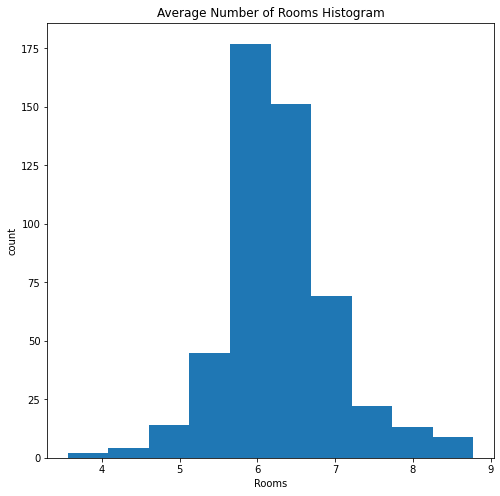

In [8]:
plt.figure(figsize=(8, 8))
plt.hist(rooms)
plt.title('Average Number of Rooms Histogram')
plt.xlabel('Rooms')
plt.ylabel('count')
plt.show()

We can see that it is decently normally distributed. Lets check the range and histogram of MEDV

Range of MEDV = { 5.0 50.0}


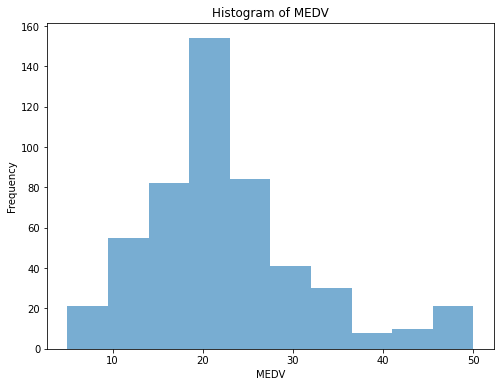

Text(0.5, 0, 'MEDV')

In [9]:
print('Range of MEDV = { ' + str(min(boston_df.MEDV)) + ' ' + str(max(boston_df.MEDV)) + '}')

ax = plt.figure(figsize=(8, 6)).gca() # define axis
boston_df.MEDV.plot.hist(ax = ax, alpha = 0.6)
plt.title('Histogram of MEDV')
plt.xlabel('MEDV')

Range of MEDV is from 5 to 50. Now lets see how MEDV(Median value of owner occupied homes) and RM(average no. of rooms per dwelling) correlate.

# Correlation

We can compute correlations between variables with the Pandas `corr()` method. The upper or lower off-diagonal elements of the 2X2 correlation matrix contain the correlation coefficients.

In [10]:
#correlation between rooms and median value
boston_df[['RM', 'MEDV']].corr().round(3)

,RM,MEDV
RM,1.000,0.695
MEDV,0.695,1.000


We see that correlation r=0.695. So in this case we have large positive link between RM and MEDV

We can also easily visualize this correlation with `ggplot2`:

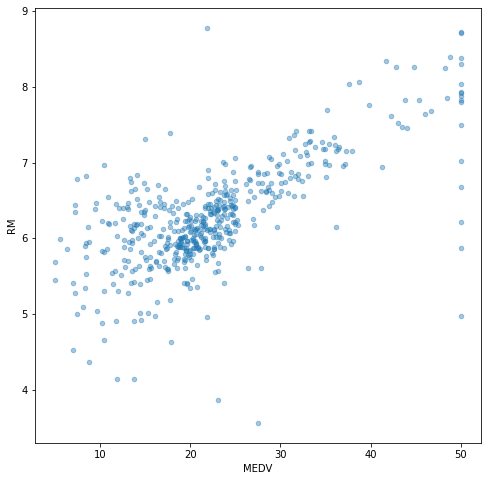

<AxesSubplot:xlabel='MEDV', ylabel='RM'>

In [11]:
ax = plt.figure(figsize=(8, 8)).gca() # define axis
boston_df.plot.scatter(x = 'MEDV', y = 'RM', ax = ax, alpha = 0.4)

If we want to test the correlation for significance, we can use the 'pearsonr' function from the scipy.stats modules. The confidence intervals can be computed using the methods in the functions below.

In [12]:
def r_z(r): ## transform distribution
    return math.log((1 + r) / (1 - r)) / 2.0

def z_r(z): ## inverse transform distribution 
    e = math.exp(2 * z)
    return((e - 1) / (e + 1))

def r_conf_int(r, alpha, n):
    # Transform r to z space
    z = r_z(r)
    # Compute standard error and critcal value in z
    se = 1.0 / math.sqrt(n - 3)
    z_crit = ss.norm.ppf(1 - alpha/2)

    ## Compute CIs with transform to r
    lo = z_r(z - z_crit * se)
    hi = z_r(z + z_crit * se)
    return (lo, hi)

def correlation_sig(df, col1, col2):
    pearson_cor = ss.pearsonr(x = df[col1], y = boston_df[col2])
    conf_ints = r_conf_int(pearson_cor[0], 0.05, 1000)
    print('Correlation = %4.3f with CI of %4.3f to %4.3f and p_value %4.3e' 
        % (pearson_cor[0], conf_ints[0], conf_ints[1], pearson_cor[1]))
    
correlation_sig(boston_df, 'MEDV', 'RM') 

Correlation = 0.695 with CI of 0.662 to 0.726 and p_value 2.487e-74


The confidence interval is fairly narrow around the correlation coefficient.

# A Simple Regression

There are many Python packages for computing linear regression models in Python. In this case we will use the `OLS` (ordinary least squares) function from the Statsmodels package. `OLS` has two arguments, the vector for the response or dependent variable, and an array containing the one or more predictor or independent variables. Notice that in order to get an intercept term ($b\_0$) the `add_constant` method must be used to add a constant column to the predictor array. A `summary` method displays a number of statistics from a `response` object.

In [13]:
## Add a constant term to the array of predictors to get an intercept term
predictors = sm.add_constant(boston_df.RM, prepend = False)

lm_mod = sm.OLS(boston_df.MEDV, predictors)
res = lm_mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     471.8
Date:                Sat, 19 Jun 2021   Prob (F-statistic):           2.49e-74
Time:                        14:55:20   Log-Likelihood:                -1673.1
No. Observations:                 506   AIC:                             3350.
Df Residuals:                     504   BIC:                             3359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RM             9.1021      0.419     21.722      0.0

The model coefficients are displayed in this summary. The intercept is shown as `const`. Thus, our regression equation is as follows:

> MEDV = -34.67 + 9.10(RM).

We have see n above in Rooms histogram that they range from 4 to 9. What if I had a relatively low <span style="font-size: 12px;">RM&nbsp;</span> score of say, 5? My predicted MEDV score would be ...

> MEDV = -34.67 + 9.10(5)

As MEDV are in $1000's then the answer would be $10830

Now, we are predicting MEDV from RM. How accurate are those predictions? To answer that, we need to discuss residuals.

# Residuals

Residuals are the difference between the actual value and the predicted value. One powerful method for understanding residuals is to make a scatter plot with the residual values on the vertical axis and the predicted values or _Score_ on the horizontal axis. This type of display is known as a _residual plot_. The code in the cell below computes predicted or score values, computes residuals and creates the residual plot:

RSE= 1.083925586274011


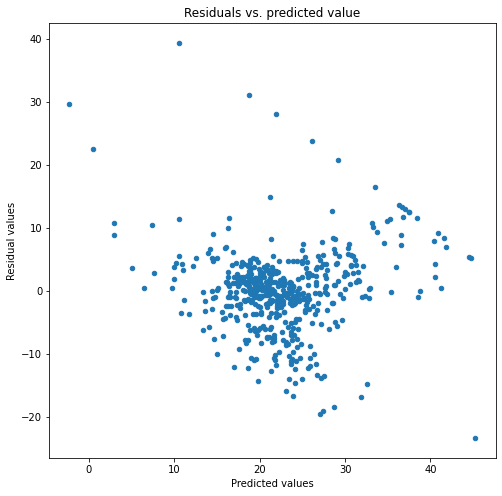

In [14]:
## Create a new data frame with the predictor value and the constant
new_predict = boston_df.RM
new_predict = sm.add_constant(new_predict, prepend = False)
## Make prediction with new values
new_predict['Score'] = res.predict(new_predict)
## Compute the residuals 
new_predict['Residuals'] = boston_df.MEDV - new_predict.Score

ax = plt.figure(figsize=(8, 8)).gca() # define axis
new_predict.plot.scatter(x='Score',y='Residuals', ax = ax)
plt.title('Residuals vs. predicted value')
plt.ylabel("Residual values")
plt.xlabel('Predicted values')

num_data = new_predict.shape[0]
mse = mean_squared_error(new_predict['Score'],new_predict['Residuals'])
rse = math.sqrt(mse/(num_data-2))
print('RSE=',rse )

We see in our our output, "Residual standard error: 1.0839", meaning our <span style="font-size: 12px;">MEDV&nbsp;</span> predictions are "off" (on average) by 1.08 points. Given that the scale is basically 5-50 (ish), this seems pretty good. Of course, we are _only_ using <span style="font-size: 12px;">RM&nbsp;</span> to predict scores right now. We could add other predictors and attempt to make this value smaller (i.e., become more accurate in our predictions).

Also importantly, one assumption of a _valid_ regression model is that the regressions are _normally distributed_. Of course, in a normal distribution, the data are symmetrical, so the lower values (1Q) should mirror the top values (3Q). We could also simply histogram them:

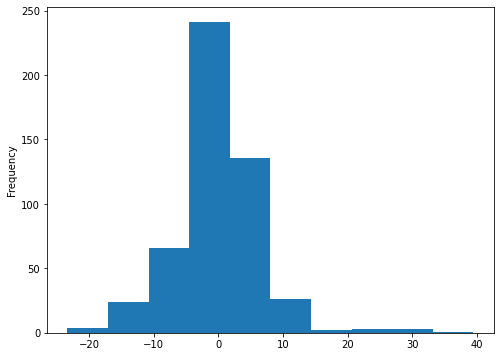

<AxesSubplot:ylabel='Frequency'>

In [38]:
ax = plt.figure(figsize=(8, 6)).gca() # define axis
new_predict.Residuals.plot.hist(ax = ax)

Our Residuals' plots shows that the Residuals are slightly skewed to the right. But our peak is approximately at zero. So we can say that we have a valid regression model. Yay!

# Alternative Hypothesis

We have a theory that tracts that border the Charles River (CHAS) will have higher median price (MEDV or target) than those that do not have the River

# Null Hypothesis

So our null hypothesis would be tracts that border the Charles River (CHAS) will not have higher median price (MEDV or target) than those that do not have the River that means that tracts that border the Charles River will have a lower or equal MEDV than those that donot have the River.

For this we need to measure means of both i.e. those which have river and those which have not

In [16]:
tracts_with_river = boston_df.loc[boston_df['CHAS'] == 1 , 'MEDV']
print(np.mean(tracts_with_river))

tracts_with_no_river = boston_df.loc[boston_df['CHAS'] == 0 , 'MEDV']
print(np.mean(tracts_with_no_river))

28.439999999999998
22.093842887473464


Mean of MEDV of tracts with river is higher than mean of MEDV of tracts with no river. Thus, our sample disagrees with the null hypothesis.

Does this _sample_ gives us enough evidence to reject the null?

To answer that question, we calculate a test statistic. we'll use the <span style="color: rgb(33, 33, 33); font-family: Consolas, &quot;Courier New&quot;, monospace; font-size: 12px; white-space: pre;">ttest_ind() </span> function from the scipy.stats library to conduct a two sample t-test.

Before we perform the test, we need to decide if we'll assume the two populations have equal variances or not. As a rule of thumb, we can assume the populations have equal variances if the ratio of the larger sample variance to the smaller sample variance is less than 4:1.

In [17]:
#find variance for each group
print(np.var(tracts_with_river), np.var(tracts_with_no_river))

135.64354285714285 77.8273718564197


The ratio of the larger sample variance to the smaller variance is 135.64 / 77.82 = 1.742, which is less than 4. This means we can assume that the population variances are equal. Thus, we can proceed to perform the two sample t-test with equal variances:

In [18]:
#perform two sample t-test with equal variances
ss.ttest_ind(a=tracts_with_river, b=tracts_with_no_river, equal_var=True)

# ss.ttest_ind_from_stats(mean1=np.mean(tracts_with_river), std1=np.sqrt(np.var(tracts_with_river)), nobs1=tracts_with_river.size,
#                      mean2=np.mean(tracts_with_no_river), std2=np.sqrt(np.var(tracts_with_no_river)), nobs2=tracts_with_no_river.size)

Ttest_indResult(statistic=3.996437466090509, pvalue=7.390623170519905e-05)

Out t statistic value is 3.996. Thus, we can literally read the result as saying "our effect was 3.99 times greater than you would typically expect by chance." That sounds pretty good for our effect and pretty bad for the null hypothesis.

Notice that the p-value is displayed in scientific notation. <span style="font-size: 12px; white-space: pre-wrap;">7.390623170519905e-05</span> is scientific notation: **<span style="color: rgb(51, 51, 51); font-family: Arial, sans-serif; font-size: 14.4px; text-align: center; background-color: rgb(255, 255, 255);">7.390623170519905 × 10</span><span style="font-size: 10.8px; line-height: 0; position: relative; vertical-align: baseline; top: -0.5em; color: rgb(51, 51, 51); font-family: Arial, sans-serif; text-align: center; background-color: rgb(255, 255, 255);">-5</span>** and means the same as <span style="color: rgb(51, 51, 51); font-family: Arial, sans-serif; font-size: 14.4px; text-align: center; background-color: rgb(255, 255, 255);"><b>0.00007390623170519905</b></span>. This is clearly less than .05 so **we can reject the null hypothesis** and conclude that tracts that border the Charles River (CHAS) will have higher median price (MEDV or target) than those that do not.

# Confidence Interval

A confidence interval simply takes your sample result and puts it at the center of a ranged estimate. We know that the sample result has error in it; it's an imperfect estimate of the population. However, we can estimate _how much error_ and can use that to create a range around our sample estimate.  

  

We have to find out that What is the 90% confidence interval for the target (price) of tracts that border the Charles River?

In [20]:
print('Range of MEDV (tracts with river) = { ' + str(min(tracts_with_river)) + ' ' + str(max(tracts_with_river)) + '}')

from scipy import stats
def t_one_sample(samp, mu = 0.0, alpha = 0.1):
    '''Function for two-sided one-sample t test'''
    t_stat = stats.ttest_1samp(samp, mu)
    scale = np.std(samp)
    loc = np.mean(samp)
    ci = stats.t.cdf(alpha/2, len(samp), loc=mu, scale=scale)
    print('Results of one-sample two-sided t test')
    print('Mean         = %4.3f' % loc)
    print('t-Statistic  = %4.3f' % t_stat[0])
    print('p-value      < %4.3e' % t_stat[1])
    print('On degrees of freedom = %4d' % (len(samp) - 1))
    print('Confidence Intervals for alpha =' + str(alpha))
    print('Lower =  %4.3f Upper = %4.3f' % (loc - ci, loc + ci))
    
t_one_sample(tracts_with_river)    

Range of MEDV (tracts with river) = { 13.4 50.0}
Results of one-sample two-sided t test
Mean         = 28.440
t-Statistic  = 14.239
p-value      < 6.874e-16
On degrees of freedom =   34
Confidence Intervals for alpha =0.1
Lower =  27.938 Upper = 28.942


We observed a sample average attitude of 28.44 (on a scale from 13.4 to 50.0). It was significant, meaning that we could reject the null hypothesis (i.e., sample result a fluke due to chance).

However, we can also say on the basis of our sample data with 90% confidence that the population average is somewhere in the range from 27.93 to 28.94.

This is **much** more useful than our _p_ \< .05 finding. Think about it. _p_ \< .05 tells us that we can reject the null hypothesis. The 90% confidence interval tells you that it's probably between 27.93 to 28.94. It both rejects the null and tells you where the population value likely is. It's rejecting the null and giving you additional information.

# Power

Here we have to find out the group size (sample size) where effect size is 0.6 and power is 80%. Let's find out:

In [21]:
from statsmodels.stats.power import tt_ind_solve_power
tt_ind_solve_power(effect_size=0.6, nobs1 = None, alpha=0.05, power=0.8, ratio=1, alternative='two-sided')

44.58579025908025

This tells us that our sample size should be 44.58 for each group if we want 80% power and 0.6 effect size.

# Experimental Design

I am considering myself as a city planner and I want to add some new features (Garage, Play area and Security camers and alarms) to each census tract.

I'll be creating a survey to know that if these features in a tract will be beneficial for the people or not. If they'll want it then ofcourse there will be an increase in the pricing values of the houses. And if they'll not then there is no means of constructing these features.

Here is the questionnaire link:

https://forms.gle/bbHpjcxpgAHvS6FN6  

In this questionnaire we have put some questions related to these features that if people want to have them or not.

Now, let's assume that not all of the tracts have shown interest in having all these 3 features in their tracts. Some have shown interest in 2 of them. Some tracts have agreed to have 1 feature in their tract.

According to their interests, we'll be start creating those features in their tracts.

After that for the data, we'll be adding 3 different columns of 3 different features for each tract. And the values will be 0 and 1 (1 is feature is there, 0 otherwise).

Let's talk about sample size we'll need for each tract. we will practice using the `tt_ind_solve_power` from the Python `statsmodels.stats.power` package for determining the minimum necessary sample size for each tract.

Usually, we start with our dream scenario. Let's ask for 90% power to detect a very small effect size (_d_ = .10). What sample size would be required?

In [32]:
tt_ind_solve_power(effect_size=0.1, nobs1 = None, alpha=0.05, power=0.9, ratio=1, alternative='two-sided')

2102.444766800448

We know that the census tract has approximately 600 to 1500 housing units. And this sample size is larger. So considering 600 housing units, let's try with 90% power and 0.2 effect size.

In [37]:
tt_ind_solve_power(effect_size=0.2, nobs1 = None, alpha=0.05, power=0.9, ratio=1, alternative='two-sided')

526.3332032147733

This looks good. I think that we can have our survey answered from 526 housing units in each tract

# Conclusion

We have done analysis on RM (our chose variable) and we have aslo performed a regression, predicting MEDV from RM.

Also, we have rejected the null hypothesis which states that the tracts that border the Charles River (CHAS) will not have higher median price (MEDV or target) than those that do not have the River

And we have also included an explanation of the experimental design for the new features along with the plan of analysis.